**Amplitude spectra analysis for five photoreceptor channels**

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import median_filter
from PIL import Image
import imageio.v2 as imageio
from scipy.fftpack import fft2, fftshift
from scipy.stats import linregress,gaussian_kde
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from scipy.stats import stats
import matplotlib.image as mpimg
import scipy
import matplotlib.cm as cm
import seaborn as sns
import os
import glob


# Outdoor amplitude spectra

In [2]:
"""
This script loads data from a specified .npz file containing L,M,S,R,iprgc responses. 
It then calculates three new variables:
- x: the sum of the 'lcone', 'mcone', and 'scone' values (l+m+s)
- y: the difference between 'lcone' and 'mcone' (l-m)
- z: the difference between 'scone' and the sum of 'lcone' and 'mcone' (s-(l+m))
"""

# This data is the .npz example of date: 20230208 and time: 17:00
data = np.load( r'\\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\1001_20230208\1001_20230208T1700\wp690_20230208T1700.npz')
l = data['lcone']
m = data['mcone']
s = data['scone']
r = data['rhodopic']
ip = data['iprgc']
stdred = data['stdred']
stdgreen = data['stdgreen']
stdblue = data['stdblue']

def impute_data(arr):
    mean_value = np.nanmedian(arr)
    arr_filled = np.where(np.isnan(arr), mean_value, arr)
    arr_filled = np.where(np.isinf(arr_filled), mean_value, arr_filled)
    return arr_filled
l = impute_data(l)
m = impute_data(m)
s = impute_data(s)
r = impute_data(r)
ip = impute_data(ip)
x = l+m+s
y = l-m
z= s-(l+m)


In [21]:
# Load the outdoor RGB image
rgb_img_path_outdoor =  r'\\kfs.kyb.local\tscn-dropbox\scenes\data\raw\1001_20230208\1001_20230208T1700\gopro10photo_20230208T1700.JPG'
rgb_img_outdoor = imageio.imread(rgb_img_path_outdoor)

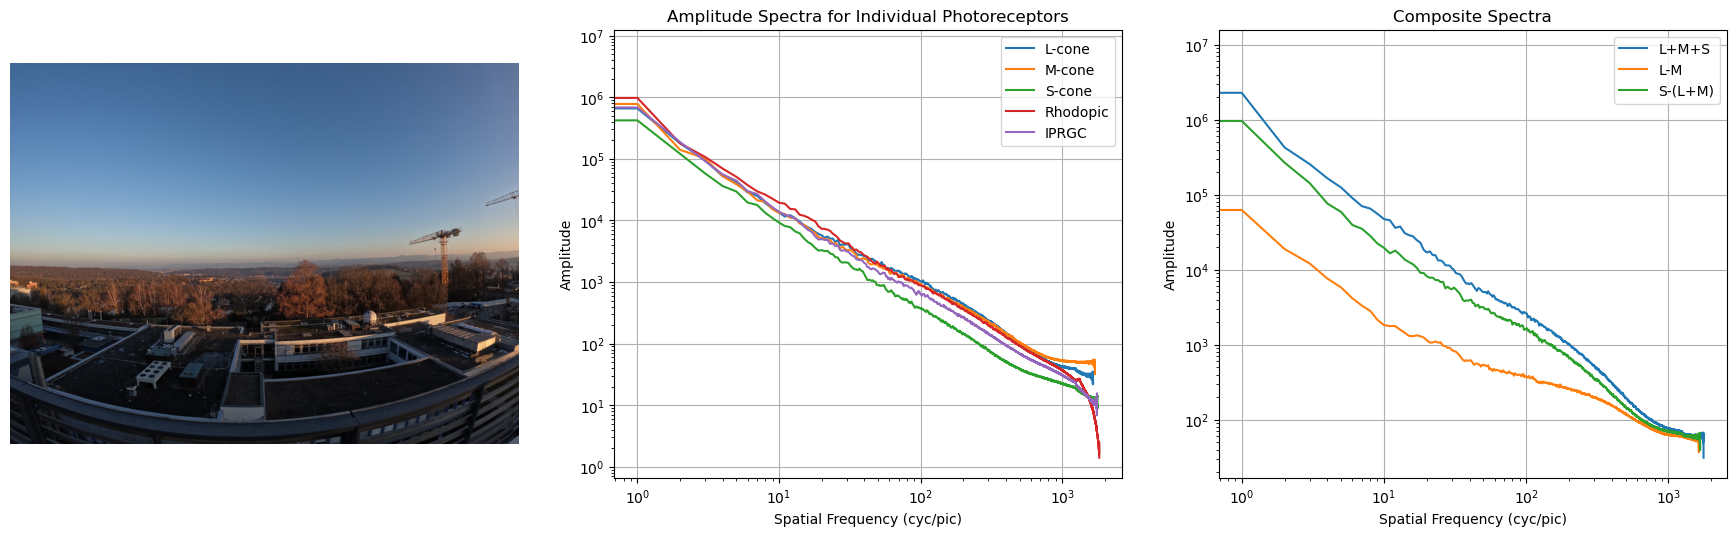

In [33]:
"""
This script analyzes images of photoreceptor responses by performing the following steps:

1. **Set Random Seed**: The random seed is set to ensure reproducibility of the random numbers generated in the script.

2. **Extract Image Patches**: The `extract_patch` function extracts a square patch of a specified size from an input image.

3. **Compute Amplitude Spectrum**: The `compute_amplitude_spectrum` function calculates the Fourier Transform of the image patch and returns the amplitude spectrum.

4. **Radial Average Calculation**: The `radial_average` function computes the radial profile of the amplitude spectrum, averaging the values based on their distance from the center.

5. **Plotting Function**: The `plot_spectra` function plots the amplitude spectra on logarithmic scales for both axes, allowing for better visualization of the data.

6. **Image Data Setup**: Lists are created for different types of photoreceptor images (L-cone, M-cone, S-cone, Rhodopic, IPRGC) and composite images derived from these.

7. **Spectrum Processing**: The script processes each image type by:
   - Extracting a patch,
   - Computing its amplitude spectrum,
   - Calculating the radial average, and storing the results.

8. **Combining Spectra**: The spectra from individual photoreceptors and composite images are combined for comparison.

9. **Plotting**: The script creates subplots to visualize the amplitude spectra for individual photoreceptors and composite spectra, alongside displaying one of the images.

The final output consists of plots that allow for analysis of the spatial frequency characteristics of the image data gathered from different photoreceptors.
"""
np.random.seed(42)  # Set this at the start of your script

def extract_patch(image, patch_size=2500):
    h, w = image.shape
    y = np.random.randint(0, h - patch_size)
    x = np.random.randint(0, w - patch_size)
    return image[y:y + patch_size, x:y + patch_size]

def compute_amplitude_spectrum(image_patch):
    fft_result = fft2(image_patch)
    fft_result = fftshift(fft_result)  # Shift the zero frequency component to the center
    amplitude_spectrum = np.abs(fft_result)
    return amplitude_spectrum

def radial_average(image, center=None):
    y, x = np.indices(image.shape)
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
    
    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / (nr + 1e-10)

    return radialprofile

def plot_spectra(ax, spectra, labels, title):
    for spectrum, label in zip(spectra, labels):
        freq = np.arange(len(spectrum))
        ax.plot(freq, spectrum, label=label)  # Plot each spectrum

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Spatial Frequency (cyc/pic)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Replace these with your actual image data
lcone = [l]  # Single image for L-cone
mcone = [m]  # Single image for M-cone
scone = [s]  # Single image for S-cone
rhodopic = [r]  # Single image for Rhodopic
iprgc = [ip]  # Single image for IPRGC
x = [lcone[0] + mcone[0] + scone[0]]
y = [lcone[0] - mcone[0]]
z = [scone[0] - (lcone[0] + mcone[0])]

# Process each category
spectra_lcone = []
spectra_mcone = []
spectra_scone = []
spectra_rhodopic = []
spectra_iprgc = []
spectra_x = []
spectra_y = []
spectra_z = []

for img in lcone:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_lcone.append(radial_spectrum)

for img in mcone:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_mcone.append(radial_spectrum)

for img in scone:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_scone.append(radial_spectrum)

for img in rhodopic:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_rhodopic.append(radial_spectrum)

for img in iprgc:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_iprgc.append(radial_spectrum)

for img in x:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_x.append(radial_spectrum)

for img in y:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_y.append(radial_spectrum)

for img in z:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_z.append(radial_spectrum)

# Combine all spectra for plotting
combined_spectra_outdoor = [
    spectra_lcone[0], 
    spectra_mcone[0], 
    spectra_scone[0], 
    spectra_rhodopic[0], 
    spectra_iprgc[0]
]

combined_spectra_composite_outdoor = [
    spectra_x[0], 
    spectra_y[0], 
    spectra_z[0],
]

labels = ["L-cone", "M-cone", "S-cone", "Rhodopic", "IPRGC"]
labels2 = ["L+M+S", "L-M", "S-(L+M)"]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot each set of spectra in separate subplots
plot_spectra(axs[1], combined_spectra_outdoor, labels, 'Amplitude Spectra for Individual Photoreceptors')
plot_spectra(axs[2], combined_spectra_composite_outdoor, labels2, 'Composite Spectra')
axs[0].imshow(rgb_img_outdoor)  # Display the L-cone image in the first subplot
axs[0].axis('off')  # Turn off axis for the image plot

plt.tight_layout(pad=3.0)  # Increase padding between subplots
plt.show()

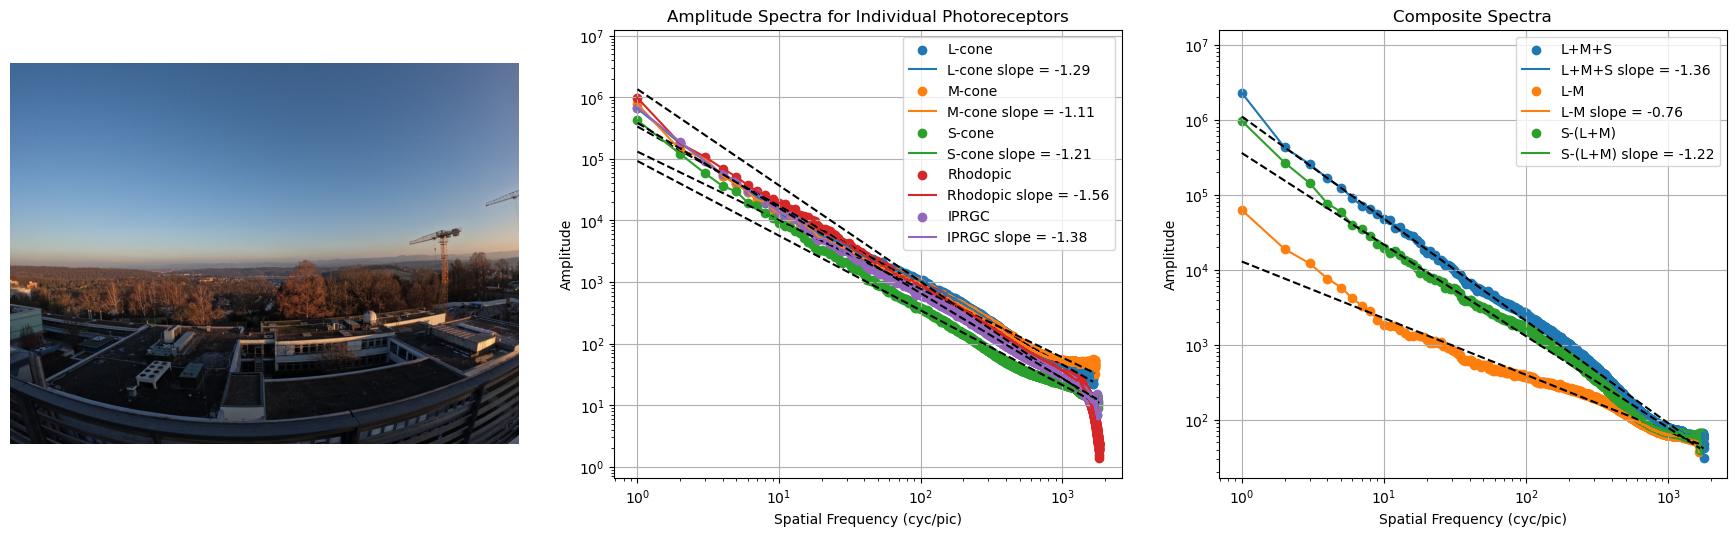

In [59]:


np.random.seed(42)  # Set this at the start of your script

# Function to extract patch from image
def extract_patch(image, patch_size=2500):
    h, w = image.shape
    y = np.random.randint(0, h - patch_size)
    x = np.random.randint(0, w - patch_size)
    return image[y:y + patch_size, x:y + patch_size]

# Function to compute amplitude spectrum
def compute_amplitude_spectrum(image_patch):
    fft_result = fft2(image_patch)
    fft_result = fftshift(fft_result)
    amplitude_spectrum = np.abs(fft_result)
    return amplitude_spectrum

# Function to compute radial average
def radial_average(image, center=None):
    y, x = np.indices(image.shape)
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
    
    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / (nr + 1e-10)

    return radialprofile

# Function to plot spectra with regression lines
def plot_spectra(ax, spectra, labels, title):
    for spectrum, label in zip(spectra, labels):
        freq = np.arange(len(spectrum))
        log_freq = np.log10(freq[1:])
        log_spectrum = np.log10(spectrum[1:])
        
        ax.scatter(freq, spectrum, label=label)

        # Linear fit to log-log data
        slope, intercept, r_value, p_value, std_err = linregress(log_freq, log_spectrum)

        # Plot
        ax.plot(freq[1:], spectrum[1:], label=f"{label} slope = {slope:.2f}")

        # Plot fitted line
        ax.plot(freq[1:], 10**(slope*log_freq + intercept), '--', color='black')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Spatial Frequency (cyc/pic)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Modify the code to include individual receptor regression lines and composite spectra regression lines

# Process each category as before

# Combine all spectra for plotting
combined_spectra_outdoor = [
    spectra_lcone[0], 
    spectra_mcone[0], 
    spectra_scone[0], 
    spectra_rhodopic[0], 
    spectra_iprgc[0]
]

combined_spectra_composite_outdoor = [
    spectra_x[0], 
    spectra_y[0], 
    spectra_z[0],
]

labels = ["L-cone", "M-cone", "S-cone", "Rhodopic", "IPRGC"]
labels2 = ["L+M+S", "L-M", "S-(L+M)"]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot each set of spectra in separate subplots with regression lines
plot_spectra(axs[1], combined_spectra_outdoor, labels, 'Amplitude Spectra for Individual Photoreceptors')
plot_spectra(axs[2], combined_spectra_composite_outdoor, labels2, 'Composite Spectra')
axs[0].imshow(rgb_img_outdoor)  # Display the L-cone image in the first subplot
axs[0].axis('off')  # Turn off axis for the image plot

plt.tight_layout(pad=3.0)  # Increase padding between subplots
plt.show()

**Time lapse slope analysis**

In [32]:

directory =  r'\\kfs.kyb.local\tscn-dropbox\scenes\data\raw\1001_20230208\1001_gopro\\'

outdoor_example = glob.glob(os.path.join(directory, '**', '*.JPG'), recursive=True)

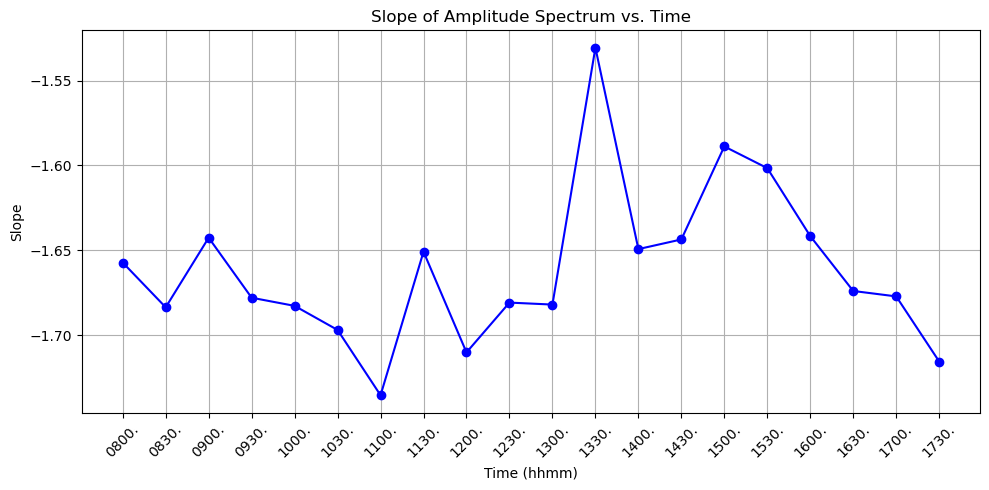

In [33]:
# Initialize lists to store slopes and timestamps
slopes = []
timestamps = []

# Process each image
for img in outdoor_example:
    gray_img_outdoor = rgb_to_grayscale(load_image(img))
    patch = extract_patch(gray_img_outdoor)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)

    # Extract timestamp from filename for labeling
    timestamp = img.split('T')[1][:5]  # Extract time portion (hhmm)
    timestamps.append(timestamp)

    # Calculate slope
    freq = np.arange(len(radial_spectrum))
    log_freq = np.log10(freq[1:])  # Skip the first element to avoid log(0)
    log_spectrum = np.log10(radial_spectrum[1:])  # Skip first element

    slope, _, _, _, _ = linregress(log_freq, log_spectrum)
    slopes.append(slope)

# Convert timestamps to a format suitable for plotting
# Here we can use simple indexing or convert to a datetime object if needed

# Create a plot of time vs. slope
plt.figure(figsize=(10, 5))
plt.plot(timestamps, slopes, marker='o', linestyle='-', color='b')
plt.xlabel('Time (hhmm)')
plt.ylabel('Slope')
plt.title('Slope of Amplitude Spectrum vs. Time')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

## Slope Time lapse animation

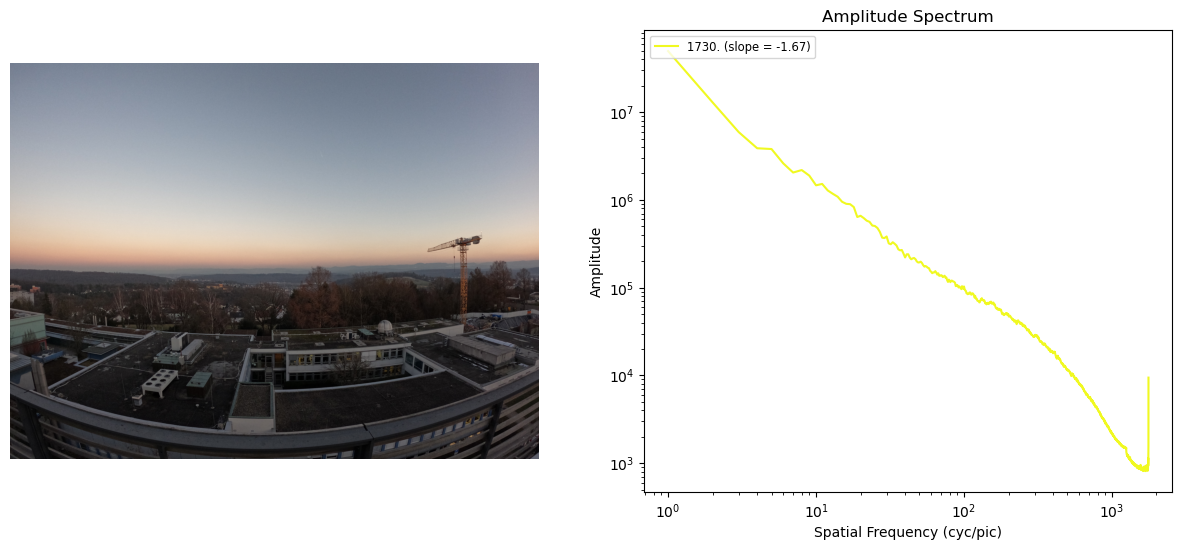

In [36]:

# Convert RGB image to Grayscale
def rgb_to_grayscale(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # Using the luminosity method

def load_image(image_path):
    img = Image.open(image_path)
    return np.array(img)  # Convert PIL image to NumPy array

def extract_patch(image, patch_size=2500):
    h, w = image.shape  # Get height and width
    y = np.random.randint(0, h - patch_size)
    x = np.random.randint(0, w - patch_size)
    return image[y:y + patch_size, x:x + patch_size]

# Compute amplitude spectrum
def compute_amplitude_spectrum(image_patch):
    fft_result = fft2(image_patch)
    fft_result = fftshift(fft_result)  # Shift the zero frequency component to the center
    amplitude_spectrum = np.abs(fft_result)
    return amplitude_spectrum

def radial_average(image, center=None):
    y, x = np.indices((image.shape))
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])

    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / (nr + 1e-10)

    return radialprofile

def plot_spectra(ax, spectrum, label, color):
    freq = np.arange(len(spectrum))
    log_freq = np.log10(freq[1:])
    log_spectrum = np.log10(spectrum[1:])

    # Linear fit to log-log data
    slope, intercept, r_value, p_value, std_err = linregress(log_freq, log_spectrum)

    # Clear and plot new spectrum
    ax.clear()
    ax.plot(freq[1:], spectrum[1:], label=f"{label} (slope = {slope:.2f})", color=color)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Spatial Frequency (cyc/pic)')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper left', fontsize='small')
    ax.set_title('Amplitude Spectrum')

# Directory path and image loading
directory = r'\\kfs.kyb.local\tscn-dropbox\scenes\data\raw\1001_20230208\1001_gopro\\'
outdoor_example = glob.glob(os.path.join(directory, '**', '*.JPG'), recursive=True)
colors = plt.cm.plasma(np.linspace(0, 1, len(outdoor_example)))  # Colormap for plots

# Prepare spectra and labels for each image
spectra_outdoor = []
labels = []
for img in outdoor_example:
    gray_img_outdoor = rgb_to_grayscale(load_image(img))
    patch = extract_patch(gray_img_outdoor)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_outdoor.append(radial_spectrum)

    # Extract timestamp from filename for labeling
    timestamp = img.split('T')[1][:5]  # Extract time portion (hhmm)
    labels.append(timestamp)

# Set up the figure and axes for animation
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Initialize the plot
def init():
    ax[0].imshow(load_image(outdoor_example[0]))
    ax[0].axis('off')  # Hide axes for the image
    plot_spectra(ax[1], spectra_outdoor[0], labels[0], colors[0])

# Update function for animation
def update(frame):
    img = load_image(outdoor_example[frame])
    ax[0].imshow(img)
    ax[0].axis('off')  # Hide axes for the image
    plot_spectra(ax[1], spectra_outdoor[frame], labels[frame], colors[frame])

# Create animation
anim = FuncAnimation(fig, update, frames=len(outdoor_example), init_func=init, repeat=True)

# To save the animation as a GIF (requires ImageMagick or Pillow)
anim.save('amplitude_spectrum_animation.gif', writer='pillow', fps=2)

# Display the animation in Jupyter Notebook or interactive window
plt.show()


## per picture analysis

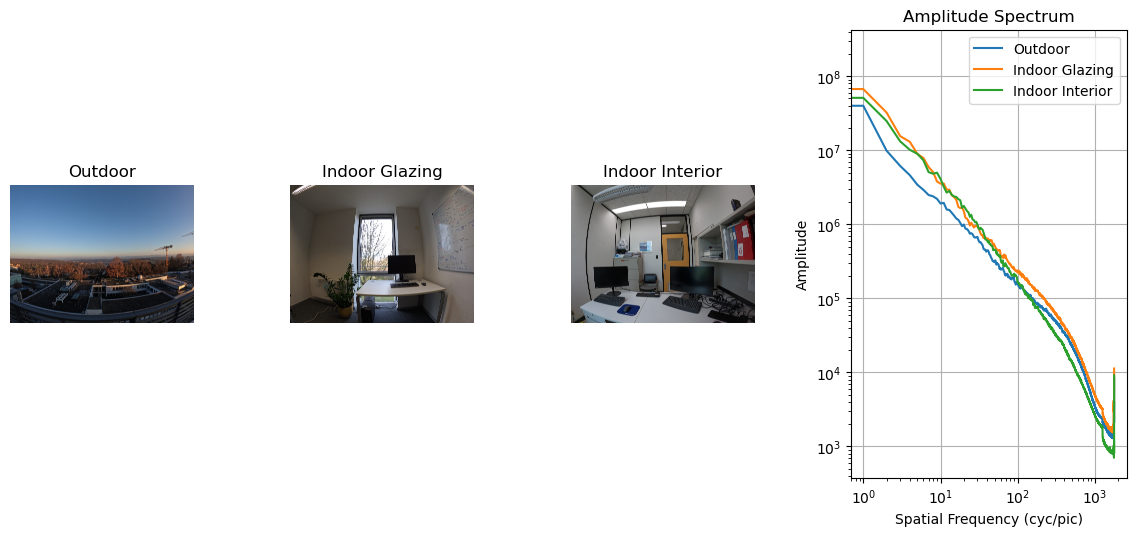

In [15]:

# Paths to the images
rgb_img_path_outdoor = r'\\kfs.kyb.local\tscn-dropbox\scenes\data\raw\1001_20230208\1001_20230208T1700\gopro10photo_20230208T1700.JPG'
rgb_img_path_glazing = r'\\kfs.kyb.local\tscn-dropbox\scenes\data\raw\1005_20230310\1005_20230310T1700\gopro10photo_20230310T1700.JPG'
rgb_img_path_interior = r'\\kfs.kyb.local\tscn-dropbox\scenes\data\raw\1010_20230612\1010_20230612T1700\gopro10photo_20230612T1700.JPG'

# Read the images
rgb_img_outdoor = imageio.imread(rgb_img_path_outdoor)
rgb_img_glazing = imageio.imread(rgb_img_path_glazing)
rgb_img_interior = imageio.imread(rgb_img_path_interior)

# Convert RGB to Grayscale
def rgb_to_grayscale(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # Using the luminosity method

# Convert the images to grayscale
gray_img_outdoor = rgb_to_grayscale(rgb_img_outdoor)
gray_img_glazing = rgb_to_grayscale(rgb_img_glazing)
gray_img_interior = rgb_to_grayscale(rgb_img_interior)

def extract_patch(image, patch_size=2500):
    h, w = image.shape  # Get height and width
    y = np.random.randint(0, h - patch_size)
    x = np.random.randint(0, w - patch_size)
    return image[y:y + patch_size, x:x + patch_size]

def compute_amplitude_spectrum(image_patch):
    fft_result = fft2(image_patch)
    fft_result = fftshift(fft_result)  # Shift the zero frequency component to the center
    amplitude_spectrum = np.abs(fft_result)
    return amplitude_spectrum

def radial_average(image, center=None):
    y, x = np.indices(image.shape)
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
    
    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / (nr + 1e-10)

    return radialprofile

def plot_spectra(ax, spectra, labels, title):
    for spectrum, label in zip(spectra, labels):
        freq = np.arange(len(spectrum))
        ax.plot(freq, spectrum, label=label)  # Plot each spectrum

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Spatial Frequency (cyc/pic)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Extract patches and compute amplitude spectra
patch_outdoor = extract_patch(gray_img_outdoor)
patch_glazing = extract_patch(gray_img_glazing)
patch_interior = extract_patch(gray_img_interior)

# Compute amplitude spectra
amplitude_spectrum_outdoor = compute_amplitude_spectrum(patch_outdoor)
amplitude_spectrum_glazing = compute_amplitude_spectrum(patch_glazing)
amplitude_spectrum_interior = compute_amplitude_spectrum(patch_interior)

# Radial average of the amplitude spectra
radial_spectrum_outdoor = radial_average(amplitude_spectrum_outdoor)
radial_spectrum_glazing = radial_average(amplitude_spectrum_glazing)
radial_spectrum_interior = radial_average(amplitude_spectrum_interior)

# Create a figure with specific layout
fig = plt.figure(figsize=(12, 6))

# Create a grid for the layout
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1.5])  # Adjust ratios for images and spectrum

# Plot images
ax_img1 = fig.add_subplot(gs[0, 0])
ax_img1.imshow(rgb_img_outdoor)  # Outdoor
ax_img1.axis('off')
ax_img1.set_title('Outdoor')

ax_img2 = fig.add_subplot(gs[0, 1])
ax_img2.imshow(rgb_img_glazing)  # Indoor glazing
ax_img2.axis('off')
ax_img2.set_title('Indoor Glazing')

ax_img3 = fig.add_subplot(gs[0, 2])
ax_img3.imshow(rgb_img_interior)  # Indoor interior
ax_img3.axis('off')
ax_img3.set_title('Indoor Interior')

# Plot amplitude spectrum
ax_spectrum = fig.add_subplot(gs[0, 3])
plot_spectra(ax_spectrum, [radial_spectrum_outdoor, radial_spectrum_glazing, radial_spectrum_interior], 
             ['Outdoor', 'Indoor Glazing', 'Indoor Interior'], 'Amplitude Spectrum')

plt.tight_layout(pad=3.0)  # Increase padding between subplots
plt.show()

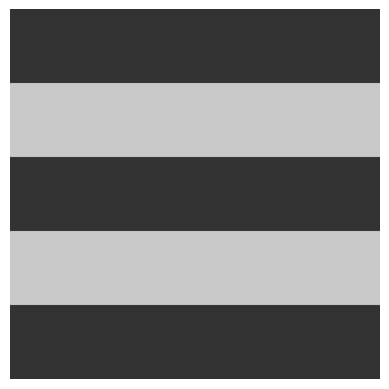

In [3]:


image_size = (555, 555)

stripes_5_freq_horz_alt = np.zeros(image_size)

# Define the height of each stripe
stripe_height = image_size[0] // 5

# Define alternating shades of gray
shades = [50, 200]

# Apply alternating shades of gray to the stripes
for i in range(5):  # We need exactly 5 stripes
    start_row = i * stripe_height
    end_row = start_row + stripe_height
    if end_row > image_size[0]:
        end_row = image_size[0]  # Ensure we do not go out of bounds
    stripes_5_freq_horz_alt[start_row:end_row, :] = shades[i % 2]

stripes_5_freq_vert_alt = np.zeros(image_size)

# Define the width of each stripe
stripe_width = image_size[1] // 5

# Define alternating shades of gray
shades = [50, 200]

# Apply alternating shades of gray to the vertical stripes
for i in range(5):  # We need exactly 5 stripes
    start_col = i * stripe_width
    end_col = start_col + stripe_width
    if end_col > image_size[1]:
        end_col = image_size[1]  # Ensure we do not go out of bounds
    stripes_5_freq_vert_alt[:, start_col:end_col] = shades[i % 2]




# Visualization
plt.imshow(stripes_5_freq_horz_alt, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()


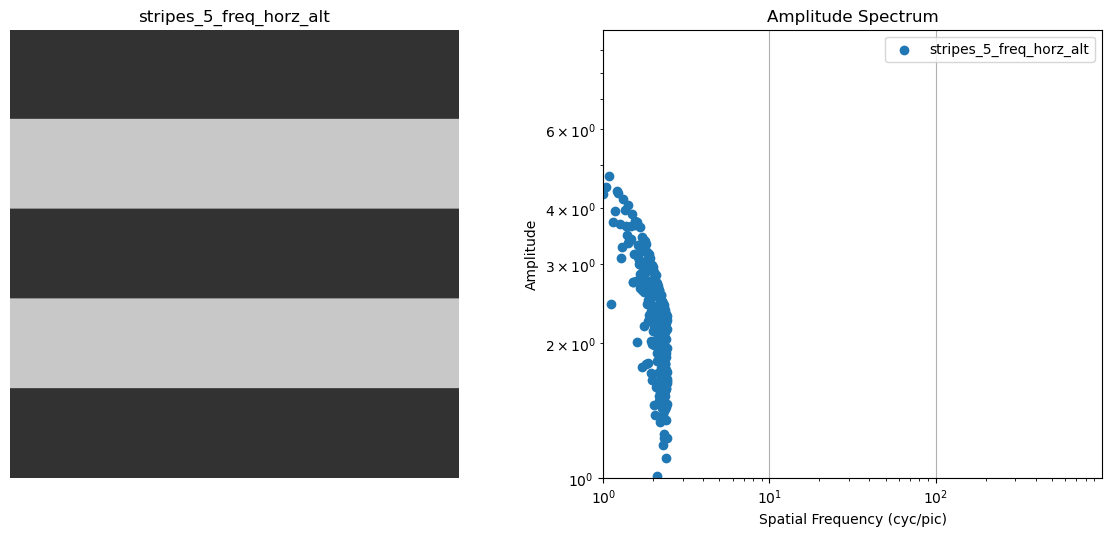

In [19]:


# # Paths to the images
# rgb_img_path_outdoor = r'\\kfs.kyb.local\tscn-dropbox\scenes\data\raw\1001_20230208\1001_20230208T1700\gopro10photo_20230208T1700.JPG'
# rgb_img_path_glazing = r'\\kfs.kyb.local\tscn-dropbox\scenes\data\raw\1005_20230310\1005_20230310T1700\gopro10photo_20230310T1700.JPG'
# rgb_img_path_interior = r'\\kfs.kyb.local\tscn-dropbox\scenes\data\raw\1010_20230612\1010_20230612T1700\gopro10photo_20230612T1700.JPG'

# # Read the images
# rgb_img_outdoor = imageio.imread(rgb_img_path_outdoor)
# rgb_img_glazing = imageio.imread(rgb_img_path_glazing)
# rgb_img_interior = imageio.imread(rgb_img_path_interior)

# Convert RGB to Grayscale
# def rgb_to_grayscale(image):
#     return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # Using the luminosity method

# # # Convert the images to grayscale
# gray_img_outdoor = rgb_to_grayscale(stripes_2_freq_horz)
# gray_img_glazing = rgb_to_grayscale(stripes_5_freq_vert)
# gray_img_interior = rgb_to_grayscale(stripes_5_freq_horz)

def extract_patch(image, patch_size=525):
    h, w = image.shape  # Get height and width
    y = np.random.randint(0, h - patch_size)
    x = np.random.randint(0, w - patch_size)
    return image[y:y + patch_size, x:x + patch_size]

def compute_amplitude_spectrum(image_patch):
    fft_result = fft2(image_patch)
    fft_result = fftshift(fft_result)  # Shift the zero frequency component to the center
    amplitude_spectrum = np.abs(fft_result)
    return amplitude_spectrum

def radial_average(image, center=None):
    y, x = np.indices(image.shape)
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
    
    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / (nr + 1e-10)

    return radialprofile

def plot_spectra(ax, spectra, labels, title):
    for spectrum, label in zip(spectra, labels):
        freq = np.arange(len(spectrum))
        log_freq = np.log10(freq[1:])
        log_spectrum = np.log10(spectrum[1:])
        ax.scatter(log_freq, log_spectrum, label=label)  # Plot each spectrum
        

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Spatial Frequency (cyc/pic)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    # Set y-axis limits and ticks
    ax.set_ylim(10**0, 10**1)
    ax.set_yticks([10**i for i in range(1)])  # Ticks from 10^0 to 10^8
    ax.set_xlim(10**0, 10**3)
    ax.set_xticks([10**i for i in range(3)])  # Ticks from 10^0 to 10^8
# Extract patches and compute amplitude spectra
patch_outdoor = extract_patch(stripes_5_freq_vert_alt)
patch_glazing = extract_patch(stripes_5_freq_horz_alt)
# patch_interior = extract_patch(stripes_5_freq_horz)

# Compute amplitude spectra
amplitude_spectrum_outdoor = compute_amplitude_spectrum(patch_outdoor)
amplitude_spectrum_glazing = compute_amplitude_spectrum(patch_glazing)
# amplitude_spectrum_interior = compute_amplitude_spectrum(patch_interior)

# Radial average of the amplitude spectra
radial_spectrum_outdoor = radial_average(amplitude_spectrum_outdoor)
radial_spectrum_glazing = radial_average(amplitude_spectrum_glazing)
# radial_spectrum_interior = radial_average(amplitude_spectrum_interior)

# Create a figure with specific layout
fig = plt.figure(figsize=(12, 6))

# Create a grid for the layout
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])  # Adjust ratios for images and spectrum

# Plot images
ax_img2 = fig.add_subplot(gs[0, 0])
ax_img2.imshow(stripes_5_freq_horz_alt, cmap='gray', vmin=0, vmax=255)
ax_img2.axis('off')
ax_img2.set_title('stripes_5_freq_horz_alt')


# Plot amplitude spectrum
ax_spectrum = fig.add_subplot(gs[0, 1])
plot_spectra(ax_spectrum, [radial_spectrum_glazing], 
             ['stripes_5_freq_horz_alt'], 'Amplitude Spectrum')

plt.tight_layout(pad=3.0)  # Increase padding between subplots
plt.show()

# Indoor glazing amplitude spectra

In [25]:
data_ig = np.load(r'\\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\1005_20230310\1005_20230310T1700\wp690_20230310T1700.npz')
l_ig = data_ig['lcone']
m_ig = data_ig['mcone']
s_ig = data_ig['scone']
r_ig = data_ig['rhodopic']
ip_ig = data_ig['iprgc']
stdred_ig = data_ig['stdred']
stdgreen_ig = data_ig['stdgreen']
stdblue_ig = data_ig['stdblue']
l_ig = impute_data(l_ig)
m_ig = impute_data(m_ig)
s_ig = impute_data(s_ig)
r_ig = impute_data(r_ig)
ip_ig = impute_data(ip_ig)
x_ig = l_ig+m_ig+s_ig
y_ig = l_ig-m_ig
z_ig= s_ig-(l_ig+m_ig)

In [26]:
#show the indoor glazing image
# Load the image
rgb_img_path_glazing =  r'\\kfs.kyb.local\tscn-dropbox\scenes\data\raw\1005_20230310\1005_20230310T1700\gopro10photo_20230310T1700.JPG'
rgb_img_glazing = imageio.imread(rgb_img_path_glazing)

In [28]:
# Replace these with your actual image data
lcone = [l_ig]  # Single image for L-cone
mcone = [m_ig]  # Single image for M-cone
scone = [s_ig]  # Single image for S-cone
rhodopic = [r_ig]  # Single image for Rhodopic
iprgc = [ip_ig]  # Single image for IPRGC
x = [lcone[0] + mcone[0] + scone[0]]
y = [lcone[0] - mcone[0]]
z = [scone[0] - (lcone[0] + mcone[0])]

# Process each category
spectra_lcone_glazing = []
spectra_mcone_glazing = []
spectra_scone_glazing = []
spectra_rhodopic_glazing = []
spectra_iprgc_glazing = []
spectra_x_glazing = []
spectra_y_glazing = []
spectra_z_glazing = []

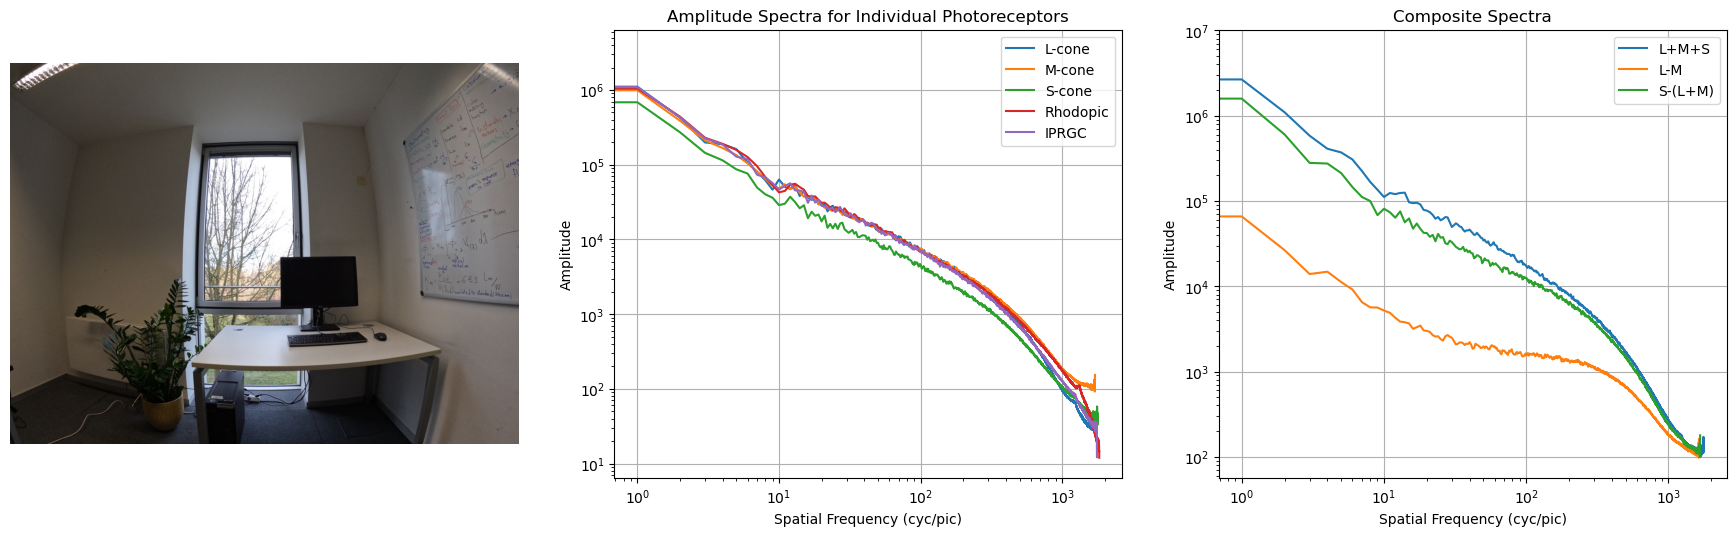

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift

np.random.seed(42)  # Set this at the start of your script

def extract_patch(image, patch_size=2500):
    h, w = image.shape
    y = np.random.randint(0, h - patch_size)
    x = np.random.randint(0, w - patch_size)
    return image[y:y + patch_size, x:y + patch_size]

def compute_amplitude_spectrum(image_patch):
    fft_result = fft2(image_patch)
    fft_result = fftshift(fft_result)  # Shift the zero frequency component to the center
    amplitude_spectrum = np.abs(fft_result)
    return amplitude_spectrum

def radial_average(image, center=None):
    y, x = np.indices(image.shape)
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
    
    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / (nr + 1e-10)

    return radialprofile

def plot_spectra(ax, spectra, labels, title):
    for spectrum, label in zip(spectra, labels):
        freq = np.arange(len(spectrum))
        ax.plot(freq, spectrum, label=label)  # Plot each spectrum

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Spatial Frequency (cyc/pic)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Replace these with your actual image data
lcone = [l_ig]  # Single image for L-cone
mcone = [m_ig]  # Single image for M-cone
scone = [s_ig]  # Single image for S-cone
rhodopic = [r_ig]  # Single image for Rhodopic
iprgc = [ip_ig]  # Single image for IPRGC
x = [lcone[0] + mcone[0] + scone[0]]
y = [lcone[0] - mcone[0]]
z = [scone[0] - (lcone[0] + mcone[0])]

# Process each category
# spectra_lcone = []
# spectra_mcone = []
# spectra_scone = []
# spectra_rhodopic = []
# spectra_iprgc = []
# spectra_x = []
# spectra_y = []
# spectra_z = []

for img in lcone:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_lcone_glazing.append(radial_spectrum)

for img in mcone:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_mcone_glazing.append(radial_spectrum)

for img in scone:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_scone_glazing.append(radial_spectrum)

for img in rhodopic:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_rhodopic_glazing.append(radial_spectrum)

for img in iprgc:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_iprgc_glazing.append(radial_spectrum)

for img in x:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_x_glazing.append(radial_spectrum)

for img in y:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_y_glazing.append(radial_spectrum)

for img in z:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_z_glazing.append(radial_spectrum)

# Combine all spectra for plotting
combined_spectra_glazing = [
    spectra_lcone_glazing[0], 
    spectra_mcone_glazing[0], 
    spectra_scone_glazing[0], 
    spectra_rhodopic_glazing[0], 
    spectra_iprgc_glazing[0]
]

combined_spectra_composite_glazing = [
    spectra_x_glazing[0], 
    spectra_y_glazing[0], 
    spectra_z_glazing[0],
]

labels = ["L-cone", "M-cone", "S-cone", "Rhodopic", "IPRGC"]
labels2 = ["L+M+S", "L-M", "S-(L+M)"]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot each set of spectra in separate subplots
plot_spectra(axs[1], combined_spectra_glazing, labels, 'Amplitude Spectra for Individual Photoreceptors')
plot_spectra(axs[2], combined_spectra_composite_glazing, labels2, 'Composite Spectra')
axs[0].imshow(rgb_img_glazing)  # Display the L-cone image in the first subplot
axs[0].axis('off')  # Turn off axis for the image plot

plt.tight_layout(pad=3.0)  # Increase padding between subplots
plt.show()

# Indoor interior amplitude spectra

In [25]:

# Load the indoor interior image
rgb_img_path_interior =  r'\\kfs.kyb.local\tscn-dropbox\scenes\data\raw\1010_20230612\1010_20230612T1700\gopro10photo_20230612T1700.JPG'
rgb_img_interior = imageio.imread(rgb_img_path_interior)


In [24]:
data_ii = np.load(r'\\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\1010_20230612\1010_20230612T1700\wp690_20230612T1700.npz')
l_ii = data_ii['lcone']
m_ii = data_ii['mcone']
s_ii = data_ii['scone']
r_ii = data_ii['rhodopic']
ip_ii = data_ii['iprgc']
stdred_ii = data_ii['stdred']
stdgreen = data_ii['stdgreen']
stdblue = data_ii['stdblue']
l_ig = impute_data(l_ii)
m_ig = impute_data(m_ii)
s_ig = impute_data(s_ii)
r_ig = impute_data(r_ii)
ip_ig = impute_data(ip_ii)
x_ii = l_ii+m_ii+s_ii
y_ii = l_ii-m_ii
z_ii= s_ii-(l_ii+m_ii)

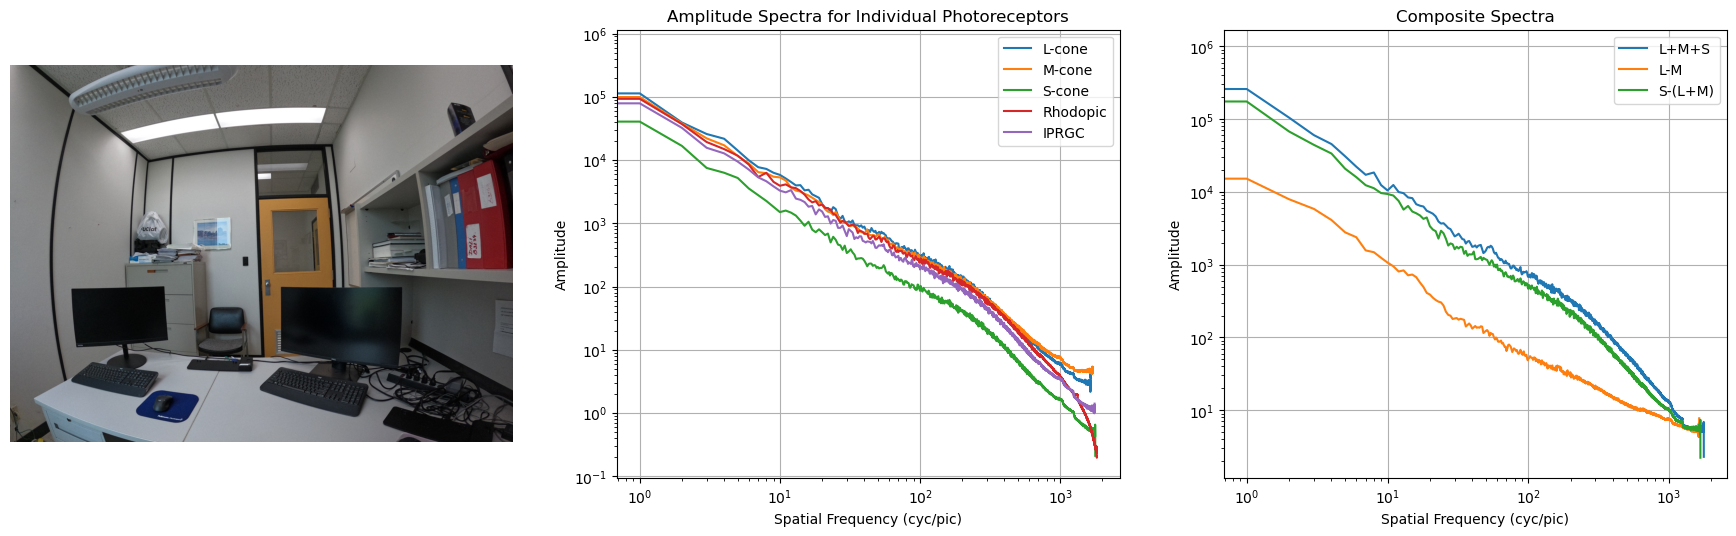

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift

np.random.seed(42)  # Set this at the start of your script

def extract_patch(image, patch_size=2500):
    h, w = image.shape
    y = np.random.randint(0, h - patch_size)
    x = np.random.randint(0, w - patch_size)
    return image[y:y + patch_size, x:y + patch_size]

def compute_amplitude_spectrum(image_patch):
    fft_result = fft2(image_patch)
    fft_result = fftshift(fft_result)  # Shift the zero frequency component to the center
    amplitude_spectrum = np.abs(fft_result)
    return amplitude_spectrum

def radial_average(image, center=None):
    y, x = np.indices(image.shape)
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
    
    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / (nr + 1e-10)

    return radialprofile

def plot_spectra(ax, spectra, labels, title):
    for spectrum, label in zip(spectra, labels):
        freq = np.arange(len(spectrum))
        ax.plot(freq, spectrum, label=label)  # Plot each spectrum

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Spatial Frequency (cyc/pic)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Replace these with your actual image data
lcone = [l_ii]  # Single image for L-cone
mcone = [m_ii]  # Single image for M-cone
scone = [s_ii]  # Single image for S-cone
rhodopic = [r_ii]  # Single image for Rhodopic
iprgc = [ip_ii]  # Single image for IPRGC
x = [lcone[0] + mcone[0] + scone[0]]
y = [lcone[0] - mcone[0]]
z = [scone[0] - (lcone[0] + mcone[0])]

# Process each category
spectra_lcone = []
spectra_mcone = []
spectra_scone = []
spectra_rhodopic = []
spectra_iprgc = []
spectra_x = []
spectra_y = []
spectra_z = []

for img in lcone:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_lcone.append(radial_spectrum)

for img in mcone:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_mcone.append(radial_spectrum)

for img in scone:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_scone.append(radial_spectrum)

for img in rhodopic:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_rhodopic.append(radial_spectrum)

for img in iprgc:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_iprgc.append(radial_spectrum)

for img in x:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_x.append(radial_spectrum)

for img in y:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_y.append(radial_spectrum)

for img in z:
    patch = extract_patch(img)
    amplitude_spectrum = compute_amplitude_spectrum(patch)
    radial_spectrum = radial_average(amplitude_spectrum)
    spectra_z.append(radial_spectrum)

# Combine all spectra for plotting
combined_spectra = [
    spectra_lcone[0], 
    spectra_mcone[0], 
    spectra_scone[0], 
    spectra_rhodopic[0], 
    spectra_iprgc[0]
]

combined_spectra_composite = [
    spectra_x[0], 
    spectra_y[0], 
    spectra_z[0],
]

labels = ["L-cone", "M-cone", "S-cone", "Rhodopic", "IPRGC"]
labels2 = ["L+M+S", "L-M", "S-(L+M)"]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot each set of spectra in separate subplots
plot_spectra(axs[1], combined_spectra, labels, 'Amplitude Spectra for Individual Photoreceptors')
plot_spectra(axs[2], combined_spectra_composite, labels2, 'Composite Spectra')
axs[0].imshow(rgb_img_interior)  # Display the L-cone image in the first subplot
axs[0].axis('off')  # Turn off axis for the image plot

plt.tight_layout(pad=3.0)  # Increase padding between subplots
plt.show()

In [54]:
# Directory containing the .npz files 
directory =  r'\\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\outdoor\\'

# Find all .npz files in the directory
outdoor = glob.glob(os.path.join(directory, '**', '*.npz'), recursive=True)

# File paths for the indoor with glazing images
# Directory containing the .npz files 
directory =  r'\\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\indoor-glazing\\'

# Find all .npz files in the directory
indoor_glazing = glob.glob(os.path.join(directory, '**', '*.npz'), recursive=True)
#indoor interior 
# Directory containing the .npz files 
directory =  r'\\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\indoor_interior\\'

# Find all .npz files in the directory
indoor_interior = glob.glob(os.path.join(directory, '**', '*.npz'), recursive=True)

# Gaussian KDE for composite images

Processing \\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\1005_20230310\1005_20230310T0930\wp690_20230310T0930.npz
Processing \\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\1005_20230310\1005_20230310T1000\wp690_20230310T1000.npz
Processing \\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\1005_20230310\1005_20230310T1030\wp690_20230310T1030.npz
Processing \\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\1005_20230310\1005_20230310T1100\wp690_20230310T1100.npz
Processing \\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\1005_20230310\1005_20230310T1130\wp690_20230310T1130.npz
Processing \\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\1005_20230310\1005_20230310T1200\wp690_20230310T1200.npz
Processing \\kfs.kyb.local\tscn-dropbox\scenes\data\derivatives\wp_derivatives\1005_20230310\1005_20230310T1230\wp690_20230310T1230.npz
Processing \\kfs.kyb.local\tscn-dropbox\scenes\d

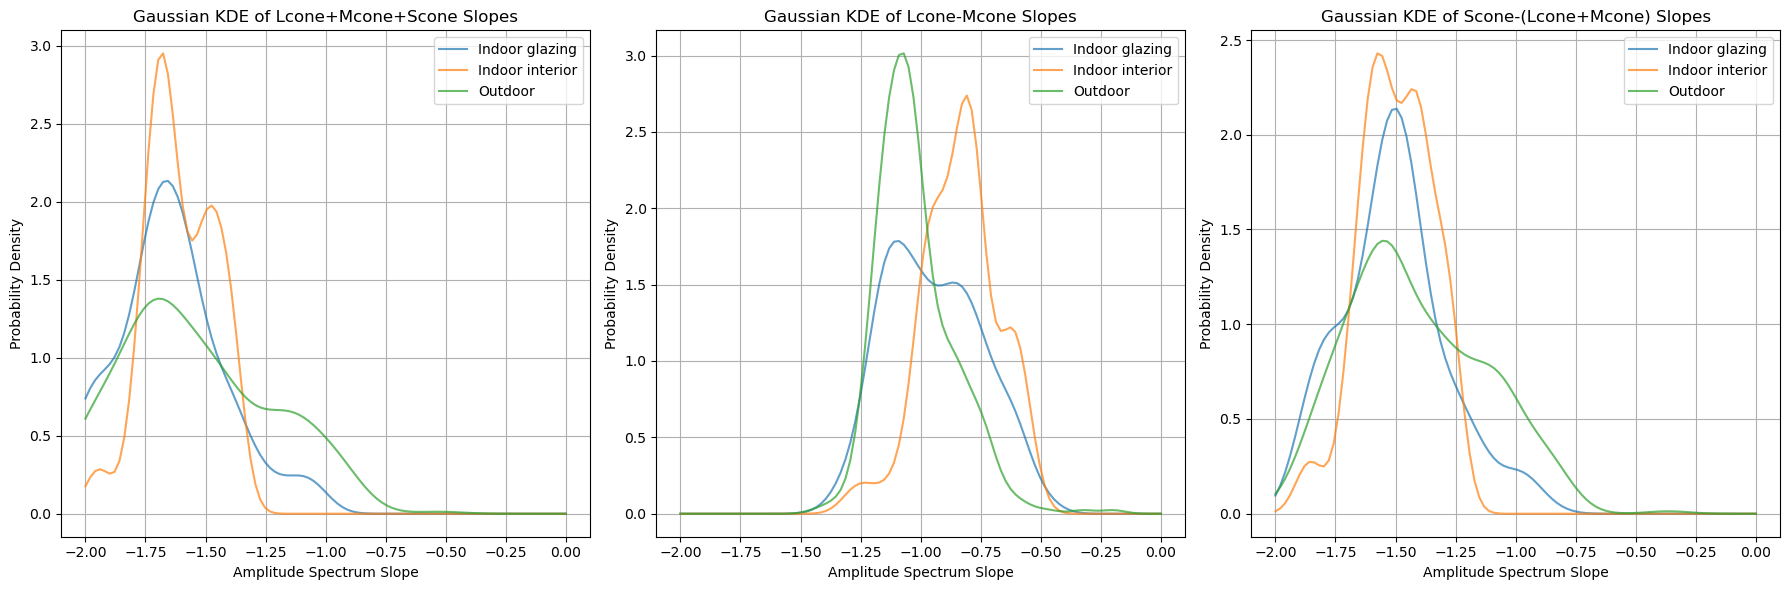

In [36]:

def extract_channel(image_path, channel_key):
    data = np.load(image_path)
    if channel_key in data:
        channel_data = impute_data(data[channel_key])
        return channel_data
    else:
        print(f"No '{channel_key}' key found in {image_path}")
        return None

def compute_amplitude_spectrum(image):
    fft_result = fft2(image)
    fft_result = fftshift(fft_result)
    amplitude_spectrum = np.abs(fft_result)
    return amplitude_spectrum

def radial_average(amplitude_spectrum):
    y, x = np.indices(amplitude_spectrum.shape)
    center = np.array([x.max() / 2, y.max() / 2])
    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), amplitude_spectrum.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = tbin / (nr + 1e-10)

    return radial_profile

def calculate_slope(radial_profile):
    frequencies = np.arange(len(radial_profile)) + 1
    log_freqs = np.log10(frequencies)
    log_amplitudes = np.log10(radial_profile + 1e-10)

    slope, _, _, _, _ = linregress(log_freqs, log_amplitudes)
    return slope

def process_images(image_paths):
    slopes = {
        'Lcone+Mcone+Scone': [],
        'Lcone-Mcone': [],
        'Scone-(Lcone+Mcone)': [],
    }
    
    for path in image_paths:
        print(f"Processing {path}")
        lcone = extract_channel(path, 'lcone')
        mcone = extract_channel(path, 'mcone')
        scone = extract_channel(path, 'scone')

        if lcone is None or mcone is None or scone is None:
            continue

        # Combine channels
        combined_image = lcone + mcone + scone
        combined_spectrum = compute_amplitude_spectrum(combined_image)
        combined_radial = radial_average(combined_spectrum)
        slopes['Lcone+Mcone+Scone'].append(calculate_slope(combined_radial))

        # Calculate slope for Lcone - Mcone
        lcone_mcone_diff = lcone - mcone
        lcone_mcone_spectrum = compute_amplitude_spectrum(lcone_mcone_diff)
        lcone_mcone_radial = radial_average(lcone_mcone_spectrum)
        slopes['Lcone-Mcone'].append(calculate_slope(lcone_mcone_radial))

        # Calculate slope for Scone - (Lcone + Mcone)
        scone_diff = scone - (lcone + mcone)
        scone_diff_spectrum = compute_amplitude_spectrum(scone_diff)
        scone_diff_radial = radial_average(scone_diff_spectrum)
        slopes['Scone-(Lcone+Mcone)'].append(calculate_slope(scone_diff_radial))

    return slopes

# Process images for each category
all_slopes = {
    'indoor_glazing': process_images(indoor_glazing),
    'indoor_interior': process_images(indoor_interior),
    'outdoor': process_images(outdoor),
}

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, slope_type in zip(axes, ['Lcone+Mcone+Scone', 'Lcone-Mcone', 'Scone-(Lcone+Mcone)']):
    for category, slopes in all_slopes.items():
        # Calculate the PDF
        density = gaussian_kde(slopes[slope_type])
        
        # Create x values for the PDF plot
        x = np.linspace(-2.0, 0, 100)
        y = density(x)  # Evaluate the density function
        
        # Normalize the PDF: Ensure the area under the curve is 1
        y /= np.trapz(y, x)  # Normalize using the trapezoidal rule

        # Plot the PDF
        ax.plot(x, y, label=category.replace('_', ' ').capitalize(),alpha=0.7)

    ax.set_xlabel('Amplitude Spectrum Slope')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'Gaussian KDE of {slope_type} Slopes')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()